In [1]:
# Python class -- WEEK 5
#
# Processing spiking data recorded during presentation of temporally
# orthogonal ripple combinations (TORCs). TORCs are stimulus designed
# for efficient white noise analysis of the auditory system. The basic
# idea is to play a lot of complex random sounds while recording the
# activity of an auditory neuron. You then find the average sound that
# evokes an increase in spiking activity
#
# Goals: 
# 1. Deal with some very practical resampling and reshaping problems. 
# 2. Visualize TORC stimulus spectrograms
# 3. Plot spike raster, showing the time of spike events aligned in
#    time to the spectrogram
# 4. Plot peristimulus time histogram (PSTH) response to the TORCs,
#    i.e., the time-varying firing rate averaged across presentations
#    of the TORC stimulus.


In [2]:
import numpy as np
import pylab as plt

import scipy.io
import scipy.signal

import strflib


In [3]:
# The data: 

# Spike data were recorded from a single neuron in primary auditory
# cortex during 2 repetitions of 30 different TORC stimuli, each 2
# seconds long and with 0.5 sec of silence before and after the
# sound. These TORCs consist of the same spectro-temporal pattern
# repeated 4 times a second. So each 2-sec stimulus effectively
# contains cycles of the same sound. The first cycle drives onset
# transients, so usually it is discarded, leaving 7 cycles of
# "steady-state" stimuluation on each trial.

In [16]:
# load contents of Matlab data file

# IC cell, easy
filepath="data/bbl031f-a1_b291_ozgf_c18_fs100.mat"

# A1 cell, harder
#filepath="data/gus025b-c1_b271_ozgf_c18_fs100.mat"

data = strflib.load_baphy_data(filepath)

In [17]:
# parse into relevant variables
# spectrogram of TORC stimuli. 15 frequency bins X 300 time samples X 30 different TORCs
stim=data['stim']
stimFs=data['stimFs']

# response matrix. spikes per bin, sampled at 100 Hz [400 time bins X 3 or 24
# repetitions X 30 different TORCs]

resp=data['resp']

# each trial is (PreStimSilence + Duration + PostStimSilence) sec long
Duration=data['Duration']
PreStimSilence=data['PreStimSilence']
respFs=data['respFs']
PostStimSilence=data['PostStimSilence']


In [18]:
# separate into fit and test data

In [19]:
# first three stimuli were repeated many (24) times and are reserved for
# validation (model testing)
validx=np.array([0,1,2])

# majority of stimuli (4-93) were repeated 3 times and are used for estimateion
estidx=np.setdiff1d(np.arange(0,93),validx)

stimest=data['stim'][:,:,estidx]
stimval=data['stim'][:,:,validx]

respest=np.nanmean(data['resp'][:,:,estidx],axis=1)
respval=np.nanmean(data['resp'][:,:,validx],axis=1)


In [20]:
X=np.reshape(stimest,[stimest.shape[0],-1],order='F')
Y=np.reshape(respest,[1,-1],order='F')
mY=np.mean(Y)
Y=Y-mY

(Hsta,Hsta0)=strflib.sta(X,Y,10)


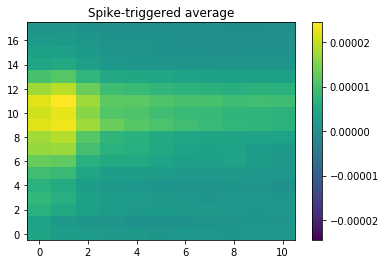

In [21]:
# display results
plt.figure()

mm=np.max(np.abs(Hsta))
plt.imshow(Hsta, origin='lower', aspect='auto', clim=(-mm,mm))
plt.colorbar()
plt.title('Spike-triggered average')
plt.show()

In [22]:
(Hnrc,Hnrc0)=strflib.norm_reverse_correlation(X,Y,10)

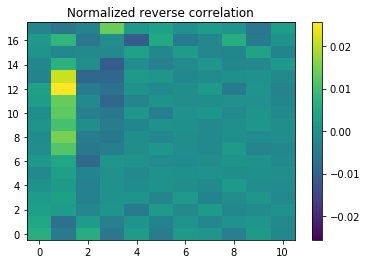

In [23]:
plt.figure()

mm=np.max(np.abs(Hnrc))
plt.imshow(Hnrc, origin='lower', aspect='auto', clim=(-mm,mm))
plt.colorbar()
plt.title('Normalized reverse correlation')
plt.show()

In [24]:
(Hcd,Hcd0)=strflib.coordinate_descent(X,Y,10)

starting CD: n_params=198, step size: 0.100000 tolerance: 0.000100
1: Backwards (delta=-0.04419488595901999), adjusting step size to 0.05
2: best step=30,0 error=0.942021278711885, delta=0.10217360724713498
3: best step=67,1 error=0.9362580533283146, delta=0.005763225383570436
4: best step=31,0 error=0.9229517672321598, delta=0.013306286096154807
5: Backwards (delta=-0.011436470875239135), adjusting step size to 0.025
6: best step=48,1 error=0.8838788982296084, delta=0.05050933987779049
7: Backwards (delta=-0.00314539452967344), adjusting step size to 0.0125
8: best step=26,0 error=0.8633510138674998, delta=0.023673278891782057
9: best step=158,1 error=0.8593522435522979, delta=0.003998770315201905
10: best step=71,0 error=0.858141047671041, delta=0.0012111958812568435
11: Backwards (delta=-0.0008086974488862309), adjusting step size to 0.00625
12: best step=27,0 error=0.8529471470346263, delta=0.006002598085301014
13: best step=62,1 error=0.8439991723368065, delta=0.008947974697819716

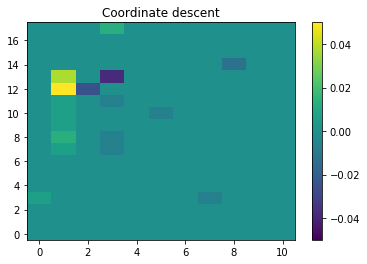

In [25]:
# display results
plt.figure()

mm=np.max(np.abs(Hcd))
plt.imshow(Hcd, origin='lower', aspect='auto', clim=(-mm,mm))
plt.colorbar()
plt.title('Coordinate descent')
plt.show()

In [26]:
# test prediction accuracy
s=stimval.shape
Xval=np.reshape(stimval,[s[0],-1],order='F')
Yval=np.reshape(respval,[1,-1],order='F')

Ypred_cd=np.reshape(strflib.predict(Xval,Hcd)+mY,[s[1],s[2]],order='F')
Ypred_sta=np.reshape(strflib.predict(Xval,Hsta)+mY,[s[1],s[2]],order='F')
Ypred_nrc=np.reshape(strflib.predict(Xval,Hnrc)+mY,[s[1],s[2]],order='F')

r_cd=np.corrcoef(Ypred_cd.flatten('F'),Yval)[0,1]
r_sta=np.corrcoef(Ypred_sta.flatten('F'),Yval)[0,1]
r_nrc=np.corrcoef(Ypred_nrc.flatten('F'),Yval)[0,1]


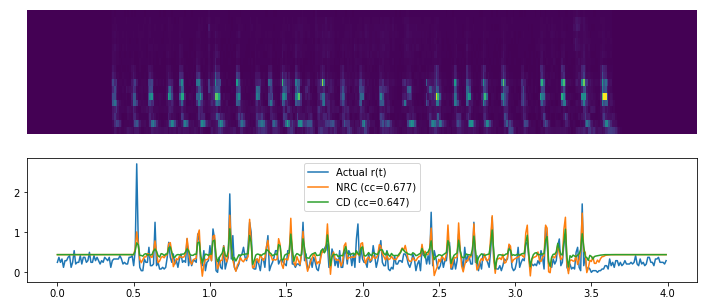

In [29]:
plt.figure(figsize=(12,5))

data_stimidx=0
tt=np.arange(0,s[1])/stimFs

plt.subplot(2,1,1)
plt.imshow(stimval[:,:,data_stimidx], origin='lower', aspect='auto')
plt.axis('off')

plt.subplot(2,1,2)
fresp,=plt.plot(tt,respval[:,data_stimidx].T,label='Actual r(t)')
fnrc,=plt.plot(tt,Ypred_nrc[:,data_stimidx].T,label="NRC (cc={0:.3f})".format(r_nrc))
fcd,=plt.plot(tt,Ypred_cd[:,data_stimidx].T,label="CD (cc={0:.3f})".format(r_cd))

plt.legend(handles=[fresp,fnrc,fcd])
#plt.tight_layout()

plt.show()